# Data Mining - Clustering

## Question 1 – Data Acquisition and Understanding

In this part, I downloaded pension fund data from the official Israeli Pension Authority website. The data was provided in XML format and converted into CSV for easier handling in Python. I then loaded the dataset into a Jupyter Notebook and verified its integrity. Additionally, I reviewed the definitions of the variables using the official data dictionary to understand their meaning and economic context before moving forward with preprocessing and analysis.

## Question 2: Data Preprocessing and Setup

In this section, we prepared the dataset for clustering analysis and imported the required Python libraries.


### Library Imports
   We imported the following packages:
   - `pandas` for data handling and manipulation.  
   - `matplotlib.pyplot` for data visualization.  
   - `sklearn.preprocessing` (StandardScaler, MinMaxScaler) for normalization and standardization.  
   - `sklearn.cluster` (KMeans) and `sklearn.mixture` (GaussianMixture) for clustering.  
   - `sklearn.metrics` (Davies-Bouldin, Calinski-Harabasz, Silhouette) to evaluate clustering quality.  
   - `matplotlib.cm` for colormap utilities.  
   - `warnings` to suppress unnecessary warnings during execution.

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import matplotlib.cm as cm
import warnings

### Data Filtering

In this step, we filtered the original dataset to include only the relevant observations:

1. **Read the dataset**  
   We loaded the pension fund data from `pension2024.csv`.

2. **Select the reporting period**  
   We kept only the records from the reporting period **December 2023** (`MI_TKUFAT_DIVUACH == 202312`).  
   This ensured that all funds are compared at the same point in time.

3. **Handle missing values**  
   We dropped rows where the cumulative return (`TSUA_MITZTABERET_LETKUFA`) was missing, since return values are essential for the analysis.

4. **Re-indexing**  
   After filtering and removing rows, we reset the DataFrame index to keep it clean and sequential.

This step prepared a consistent dataset for the next preprocessing stages.


In [194]:
file_path = r"pension2024.csv"
original_df = pd.read_csv(file_path)
original_df = original_df[original_df['MI_TKUFAT_DIVUACH'] == 202312]
original_df = original_df.reset_index(drop=True)
# print(original_df.loc[:, 'MI_TKUFAT_DIVUACH'])
original_df = original_df.dropna(subset=['TSUA_MITZTABERET_LETKUFA'])
original_df = original_df.reset_index(drop=True)

### Feature Selection

In this step, we created a new DataFrame containing only the relevant columns needed for the analysis:

- **Fund and company identifiers:**  
  `SHM_HEVRA_MENAHELET`, `SHM_KRN`, `ID`, `SUG_KRN`, `SUG_TAAGID_SHOLET`

- **Transaction-related variables:**  
  `MSHICHOT_LLO_HAAVAROT` (Withdrawals without transfers),  
  `HAFKADOT_LLO_HAAVAROT` (Deposits without transfers),  
  `TZVIRA_NETO` (Net accumulation),  
  `HAAVAROT_BEIN_HAKRANOT` (Transfers between funds)

- **Financial performance variables:**  
  `YITRAT_NCHASIM_LSOF_TKUFA` (End-of-period asset balance),  
  `TSUA_MITZTABERET_LETKUFA` (Cumulative return for the period)

By keeping only these columns, we ensured that the dataset contained the essential variables for further preprocessing, feature engineering, and clustering analysis, while removing irrelevant information.

In [197]:
columns_to_save = [
    'SHM_HEVRA_MENAHELET', 'SHM_KRN', 'ID', 'SUG_KRN', 'SUG_TAAGID_SHOLET',
    'MSHICHOT_LLO_HAAVAROT', 'HAFKADOT_LLO_HAAVAROT', 'TZVIRA_NETO',
    'HAAVAROT_BEIN_HAKRANOT', 'YITRAT_NCHASIM_LSOF_TKUFA', 'TSUA_MITZTABERET_LETKUFA'
]
new_df = original_df[columns_to_save].copy()

### Data Cleaning: Correcting Inconsistent Labels

In this step, we corrected inconsistent categorical values in the dataset.  
Specifically, for all rows where the managing company (`SHM_HEVRA_MENAHELET`) was **"כלל פנסיה וגמל בע"מ"**,  
we updated the controlling entity (`SUG_TAAGID_SHOLET`) to **"קבוצת אחזקה כלל"**.

This replacement ensured consistent labeling of company ownership, which is important for accurate grouping and analysis of the funds.


In [200]:
condition_column = 'SHM_HEVRA_MENAHELET'
condition_value = 'כלל פנסיה וגמל בע"מ'
change_column = 'SUG_TAAGID_SHOLET'
new_value = 'קבוצת אחזקה כלל'
new_df.loc[new_df[condition_column] == condition_value, change_column] = new_value

### Feature Engineering: Creating Ratio Variables

To make the data comparable across pension funds of different sizes,  
we created new ratio-based variables by dividing each transaction measure by the total end-of-period asset balance (`YITRAT_NCHASIM_LSOF_TKUFA`):

- **Net Accumulation Ratio**  
  `TZVIRA_NETO / YITRAT_NCHASIM_LSOF_TKUFA`  
  → Measures the proportion of net accumulation relative to the fund’s total assets.

- **Deposit Ratio**  
  `HAFKADOT_LLO_HAAVAROT / YITRAT_NCHASIM_LSOF_TKUFA`  
  → Indicates the size of deposits relative to the fund’s total assets.

- **Withdrawal Ratio**  
  `MSHICHOT_LLO_HAAVAROT / (-1 * YITRAT_NCHASIM_LSOF_TKUFA)`  
  → Expresses withdrawals as a negative proportion of the fund’s assets,  
  highlighting their reducing effect on the balance.

- **Transfer Ratio**  
  `HAAVAROT_BEIN_HAKRANOT / YITRAT_NCHASIM_LSOF_TKUFA`  
  → Captures the relative importance of transfers between funds.

These ratio variables normalize fund activities and ensure fair comparison across funds with very different asset sizes.


In [203]:
new_df['TZVIRA_NETO/YITRAT_NCHASIM_LSOF_TKUFA'] = new_df['TZVIRA_NETO'] / new_df['YITRAT_NCHASIM_LSOF_TKUFA']
new_df['HAFKADOT_LLO_HAAVAROT/YITRAT_NCHASIM_LSOF_TKUFA'] = new_df['HAFKADOT_LLO_HAAVAROT'] / new_df[
    'YITRAT_NCHASIM_LSOF_TKUFA']
new_df['MSHICHOT_LLO_HAAVAROT/(-1)*YITRAT_NCHASIM_LSOF_TKUFA'] = new_df['MSHICHOT_LLO_HAAVAROT'] / (
        -1 * new_df['YITRAT_NCHASIM_LSOF_TKUFA'])
new_df['HAAVAROT_BEIN_HAKRANOT/YITRAT_NCHASIM_LSOF_TKUFA'] = new_df['HAAVAROT_BEIN_HAKRANOT'] / new_df[
    'YITRAT_NCHASIM_LSOF_TKUFA']

### Descriptive Statistics

At this step, we generated summary statistics for all numerical variables in the dataset using  
`pandas.DataFrame.describe()`.

- **Mean** – shows the average value of each variable.  
- **Standard deviation** – indicates the variability or spread of the data.  
- **Minimum and Maximum** – highlight the range of values, helping to detect outliers.  
- **Quartiles (25%, 50%, 75%)** – provide insights into the distribution of the variables.  

This statistical overview allowed us to identify patterns such as skewness (e.g., very large maximum values compared to the mean),  
possible negative ratios (indicating losses or outflows), and the relative variability of each feature.  
It also served as a foundation for interpreting what high or low values of each variable mean in practical terms.

In [206]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(new_df.describe())

                 ID  MSHICHOT_LLO_HAAVAROT  HAFKADOT_LLO_HAAVAROT  \
count    131.000000             131.000000             131.000000   
mean    9321.465649             267.784885             560.428015   
std     4882.139210             592.454428            1173.325729   
min     1589.000000               0.010000               0.000000   
25%     2202.000000               3.650000               0.610000   
50%     9975.000000              23.450000              18.390000   
75%    13912.500000             222.020000             558.460000   
max    14850.000000            4280.400000            5960.300000   

        TZVIRA_NETO  HAAVAROT_BEIN_HAKRANOT  YITRAT_NCHASIM_LSOF_TKUFA  \
count    131.000000              131.000000                 131.000000   
mean     510.651298              218.008168                6769.424733   
std     2086.880019             2254.713805               14064.440034   
min    -7796.380000            -9143.040000                   0.350000   
25%     

### Summary Statistics of Pension Fund Data

#### Original Variables

| Variable | Description | Mean | Std. Dev | Min | Max | Explanation |
|----------|-------------|------|----------|-----|-----|-------------|
| ID | - | N/A | N/A | N/A | N/A | Identifier of the fund |
| Withdrawals without Transfers | Withdrawals from the pension fund (million ₪) | 267.78 | 592.45 | 0.01 | 4280.4 | 75th percentile is close to the mean, max is much higher → right-skewed |
| Deposits without Transfers | Deposits into the pension fund (million ₪) | 560.43 | 1173.33 | 0 | 5960.3 | 75th percentile near mean, max much higher → right-skewed |
| Net Accumulation | Deposits + Transfers - Withdrawals | 510.65 | 2086.88 | -7796.38 | 12112.37 | Std. dev large relative to mean; some funds lost money |
| Transfers Between Funds | Transfers from/to other pension funds (million ₪) | 218.01 | 2254.71 | -9143.04 | 10345.65 | Std. dev very large; some funds transferred out more than received |
| Fund Value at Period End | Fund value at the end of the period (million ₪) | 6769.42 | 14064.44 | 0.35 | 102997.92 | Large range → some very large funds versus small funds |
| Cumulative Return | Cumulative return (%) | 13.91 | 5.15 | 5.33 | 25.4 | Std. dev low relative to mean; distribution approximately normal |

---

#### Derived Ratios

| Variable | Description | Mean | Std. Dev | Min | Max | Explanation |
|----------|-------------|------|----------|-----|-----|-------------|
| Net Accumulation / End Fund Value | Ratio of net accumulation to total fund value at period end | 0.267832 | 0.326526 | -0.393147 | 1.028571 | Average accumulation ~26% of fund value; high → high accumulation relative to fund; negative → loss |
| Deposits / End Fund Value | Ratio of deposits to total fund value at period end | 0.071114 | 0.061748 | 0 | 0.396015 | Average deposits low relative to fund; high → high contribution from deposits; low → low contribution |
| Withdrawals / End Fund Value × (-1) | Adjusted ratio of withdrawals to fund value | -0.061156 | 0.073347 | -0.428571 | -0.000332 | Average withdrawals low relative to fund; high (less negative) → low withdrawals; low (more negative) → high withdrawals; negative → fund losses |
| Transfers Between Funds / End Fund Value | Ratio of transfers relative to end fund value | 0.257875 | 0.325207 | -0.209405 | 1.314286 | High → high transfers into fund; negative → more transferred out than in; >1 → transfers exceeded fund value |

---

### Observations

- Many variables show **right-skewed distributions** (large max values relative to the mean), indicating the presence of **outliers**.  
- Ratios provide a normalized view of contributions, withdrawals, and net accumulation relative to the fund size.  
- Negative values in net accumulation or adjusted withdrawals highlight **funds that lost money** during the period.  
- Ratios larger than 1 indicate **accumulation or transfers exceeding the total fund value**, which can occur due to timing or fund-specific movements.  


## Question 3: The relationship between pension funds and returns

In this step, we focused on selecting the variables that would be used in the clustering analysis.

### Selecting variables
1. **Rationale for keeping end-of-period assets and cumulative return**  
   By keeping both **"End-of-period Assets" (`YITRAT_NCHASIM_LSOF_TKUFA`)** and  
   **"Cumulative Return for the Period" (`TSUA_MITZTABERET_LETKUFA`)**, we gain a more complete picture of each fund’s financial position and performance.  
   - The asset balance reflects the fund’s size and stability.  
   - The cumulative return reflects its investment performance.  
   Together, these variables allow us to understand how investor actions (deposits and withdrawals) influence the fund’s value and its ability to generate returns.  

   High variance in these variables may indicate large differences between funds in size or performance,  
   while low variance would suggest relative uniformity.  
   Analyzing this variance helps to identify outlier funds (very successful or underperforming) and to better understand the strategies or risk levels that explain these differences.

2. **Choice of variables for clustering**  
   For the new dataset, we decided to use the **original transaction variables** rather than the ratio-based ones.  
   The original variables contain all the necessary financial information, and in the next step we will apply **normalization/standardization** to make them comparable.  
   Since the ratio variables already involve division by the total assets, adding further normalization at this stage would have been redundant.

3. **Implementation in code**  
   We built a clean dataset (`clean_df`) that contains the following variables:  
   - Net accumulation (`TZVIRA_NETO`)  
   - Deposits without transfers (`HAFKADOT_LLO_HAAVAROT`)  
   - Withdrawals without transfers (`MSHICHOT_LLO_HAAVAROT`)  
   - Transfers between funds (`HAAVAROT_BEIN_HAKRANOT`)  
   - End-of-period asset balance (`YITRAT_NCHASIM_LSOF_TKUFA`)  
   - Cumulative return for the period (`TSUA_MITZTABERET_LETKUFA`)  

   This dataset will be the basis for normalization and clustering in the following steps.

In [211]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
columns_to_save = ['TZVIRA_NETO', 'HAFKADOT_LLO_HAAVAROT', 'MSHICHOT_LLO_HAAVAROT', 'HAAVAROT_BEIN_HAKRANOT',
                   'YITRAT_NCHASIM_LSOF_TKUFA', 'TSUA_MITZTABERET_LETKUFA']
clean_df = new_df[columns_to_save]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(clean_df)

     TZVIRA_NETO  HAFKADOT_LLO_HAAVAROT  MSHICHOT_LLO_HAAVAROT  \
0        1249.24                 134.59                   7.22   
1       -5418.28                3037.23                1964.73   
2         -16.59                  80.60                  29.62   
3       -7796.38                5627.06                4280.40   
4         136.08                 608.40                1889.23   
5         823.91                 604.90                 506.60   
6         935.85                 857.74                 437.26   
7         981.35                1211.73                 576.94   
8         887.57                1398.35                 592.36   
9         559.55                 434.94                 128.17   
10      -4796.16                3831.19                 897.14   
11         41.84                  11.17                   1.48   
12        442.89                 139.40                   7.86   
13         57.71                 233.43                  20.24   
14       1

### Transformations
Normalization or standardization is required so that we can compare the funds fairly, even when one fund has a higher balance than the other. For example, there may be two funds, one with a higher balance and the other with a lower balance, but although the first fund may show a higher accumulation in shekels, its accumulation percentage may be lower. Therefore, in order to avoid these biases towards variables with wider numerical ranges, we will construct the data set so that each variable affects the result equally.

In [214]:
def Z_Standardization(df):
    columns_to_standardize = df.columns
    scaler = StandardScaler()
    df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=columns_to_standardize)
    return df_standardized

def normal_min_max(df):
    columns_to_normalize = df.columns
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=columns_to_normalize)
    return df_normalized

df_Z_Standardization = Z_Standardization(clean_df)
df_normal_min_max = normal_min_max(clean_df)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df_Z_Standardization.describe())
print(df_normal_min_max.describe())

        TZVIRA_NETO  HAFKADOT_LLO_HAAVAROT  MSHICHOT_LLO_HAAVAROT  \
count  1.310000e+02           1.310000e+02           1.310000e+02   
mean  -2.711995e-17          -5.423990e-17          -6.779988e-17   
std    1.003839e+00           1.003839e+00           1.003839e+00   
min   -3.995879e+00          -4.794742e-01          -4.537105e-01   
25%   -2.460202e-01          -4.789523e-01          -4.475430e-01   
50%   -2.242924e-01          -4.637406e-01          -4.139944e-01   
75%    1.548217e-01          -1.683735e-03          -7.754279e-02   
max    5.580702e+00           4.619860e+00           6.798867e+00   

       HAAVAROT_BEIN_HAKRANOT  YITRAT_NCHASIM_LSOF_TKUFA  \
count              131.000000               1.310000e+02   
mean                 0.000000              -8.135986e-17   
std                  1.003839               1.003839e+00   
min                 -4.167706              -4.831376e-01   
25%                 -0.097023              -4.778745e-01   
50%               

#### Data Standardization and Normalization

In the code above, we applied two common preprocessing techniques to the dataset `clean_df`: **Z-Standardization** and **Min-Max Normalization**.  

**1. Z-Standardization (Standard Scaling)**
- Implemented in the function `Z_Standardization`.
- Formula for each value:

\[
z = \frac{x - \mu}{\sigma}
\]

- Transforms data so that each feature has **mean = 0** and **standard deviation = 1**.
- Useful for algorithms sensitive to feature scale, e.g., **KNN, SVM, PCA**.

**2. Min-Max Normalization (Scaling to [0, 1])**
- Implemented in the function `normal_min_max`.
- Formula for each value:

\[
x' = \frac{x - x_{min}}{x_{max} - x_{min}}
\]

- Scales features to a fixed range, typically between 0 and 1.
- Useful for algorithms requiring bounded input, e.g., **neural networks**.

Finally, the transformed datasets are stored in `df_Z_Standardization` and `df_normal_min_max`. We used `describe()` to check the effect of scaling and observe summary statistics.


#### Z-Score Standardization (Z-Normalization)

| Variable | Mean | Std. Dev | Min | Max | Explanation of High/Low Values |
|----------|------|----------|-----|-----|--------------------------------|
| Cumulative Return | 0 | 1.003839 | -1.67147 | 2.240525 | High positive value → significantly above average return; high negative → significantly below average return |
| Fund Value at Period End | 0 | 1.003839 | -0.483138 | 6.868236 | High positive → significantly above average fund value; high negative → significantly below average fund value |
| Transfers Between Funds | 0 | 1.003839 | -4.16770 | 4.509007 | High positive → high transfers into fund; high negative → high transfers out of fund |
| Withdrawals Without Transfers | 0 | 1.003839 | -0.453711 | 6.798867 | High positive → high withdrawals; high negative → low withdrawals |
| Deposits Without Transfers | 0 | 1.003839 | -0.47947 | 4.61986 | High positive → high deposits; high negative → low deposits |
| Net Accumulation | 0 | 1.003839 | -3.995879 | 5.580702 | High positive → high net accumulation; high negative → low net accumulation |

---

#### Min-Max Normalization

| Variable | Mean | Std. Dev | Min | Max | Explanation of High/Low Values |
|----------|------|----------|-----|-----|--------------------------------|
| Cumulative Return | 0.427268 | 0.256605 | 0 | 1 | High → above average return; low → below average return |
| Fund Value at Period End | 0.065721 | 0.136551 | 0 | 1 | High → above average fund value; low → below average fund value |
| Transfers Between Funds | 0.480332 | 0.115693 | 0 | 1 | High → high transfers into fund; low → high transfers out of fund |
| Withdrawals Without Transfers | 0.062559 | 0.138411 | 0 | 1 | High → high withdrawals; low → low withdrawals |
| Deposits Without Transfers | 0.094027 | 0.196857 | 0 | 1 | High → high deposits; low → low deposits |
| Net Accumulation | 0.417255 | 0.104822 | 0 | 1 | High → high net accumulation; low → low net accumulation |

---

#### Explanation

The dataset contains **outliers**, making **Z-Score Standardization** a preferred choice for clustering algorithms like **KMeans** and **GMM**.  

- Z-Standardization reduces the influence of varying scales across features, unlike Min-Max normalization, which only rescales values to a fixed range.  
- Clustering algorithms rely on **distance calculations**, so unstandardized data with different scales can bias results toward features with larger ranges.  
- Z-Standardization ensures all features contribute equally to distance computations, improving clustering accuracy and model performance.  
- It also reduces the impact of outliers and can decrease algorithm convergence time, leading to more reliable and precise results.


### Clustering Evaluation Using GMM and KMeans

In this code, we are performing clustering on the **standardized parametric variables** (`df_Z_Standardization`) and evaluating the quality of clusters using three metrics:  

1. **Davies-Bouldin Score (DB)** – lower values indicate better separation between clusters.  
2. **Calinski-Harabasz Score (CH)** – higher values indicate better-defined clusters.  
3. **Silhouette Score (S)** – ranges from -1 to 1; higher values indicate more cohesive and well-separated clusters.  

In [219]:
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
parametric_variables_standardized = df_Z_Standardization
k_values = range(4, 31)
GMM_results = []

for k in k_values:
    GMM = GaussianMixture(n_components=k, random_state=3)
    GMM_clusters = GMM.fit_predict(parametric_variables_standardized)
    GMM_davies_bouldin = davies_bouldin_score(parametric_variables_standardized, GMM_clusters)
    GMM_calinski_harabasz = calinski_harabasz_score(parametric_variables_standardized, GMM_clusters)
    GMM_silhouette = silhouette_score(parametric_variables_standardized, GMM_clusters)
    GMM_results.append({'K': k,
                        'Davies-Bouldin Score': GMM_davies_bouldin,
                        'Calinski-Harabasz Score': GMM_calinski_harabasz,
                        'Silhouette Score': GMM_silhouette, })

GMM_results_df = pd.DataFrame(GMM_results)
# print(GMM_results_df)
# GMM_results_df.to_csv('GMM_result.csv', index=False)

KMeans_results = []
for k in range(4, 31):
    KMeans_model = KMeans(n_clusters=k, random_state=3)
    KMeans_clusters = KMeans_model.fit_predict(parametric_variables_standardized)
    KMeans_davies_bouldin = davies_bouldin_score(parametric_variables_standardized, KMeans_clusters)
    KMeans_calinski_harabasz = calinski_harabasz_score(parametric_variables_standardized, KMeans_clusters)
    KMeans_silhouette = silhouette_score(parametric_variables_standardized, KMeans_clusters)

    KMeans_results.append({
        'K': k,
        'Davies-Bouldin Score': KMeans_davies_bouldin,
        'Calinski-Harabasz Score': KMeans_calinski_harabasz,
        'Silhouette Score': KMeans_silhouette
    })

KMeans_results_df = pd.DataFrame(KMeans_results)
# KMeans_results_df.to_csv('KMeans_result.csv', index=False)


#### Steps:

1. **Prepare Data**  
   - Standardized variables are stored in `parametric_variables_standardized`.  
   - Suppress a known KMeans warning about memory leaks.  
   - Reset Pandas display options for readability.  

2. **Gaussian Mixture Model (GMM) Evaluation**  
   - Loop over `k` from 4 to 30 (number of clusters).  
   - Fit a GMM with `k` components.  
   - Predict cluster labels for each data point.  
   - Compute the three evaluation metrics (DB, CH, Silhouette).  
   - Store results in `GMM_results_df`.  

3. **KMeans Evaluation**  
   - Loop over the same range of `k`.  
   - Fit a KMeans model with `k` clusters.  
   - Predict cluster labels.  
   - Compute the same three evaluation metrics.  
   - Store results in `KMeans_results_df`.  

#### Notes:

- Comparing the metrics between GMM and KMeans helps to **choose the optimal number of clusters**.  
- Standardizing the variables ensures all features contribute equally to distance calculations, which is crucial for both KMeans and GMM.  
- The results can be saved to CSV files for later analysis or visualization.


### Tabular presentation of **KMEANS** algorithm results

The table below shows the evaluation metrics for **different numbers of clusters (K)**:

| K | Davies-Bouldin Score | Calinski-Harabasz Score | Silhouette Score |
|---|--------------------|------------------------|----------------|
| 4  | 0.8198  | 95.8143   | 0.3976 |
| 5  | 0.9081  | 99.7654   | 0.4383 |
| 6  | 0.8168  | 113.0032  | 0.4513 |
| 7  | 0.7596  | 122.8288  | 0.4573 |
| 8  | 0.7831  | 129.4119  | 0.4708 |
| 9  | 0.7471  | 137.6384  | 0.4557 |
| 10 | 0.6813  | 136.9409  | 0.4536 |
| 11 | 0.5873  | 146.4173  | 0.4509 |
| 12 | 0.6962  | 136.6136  | 0.4410 |
| 13 | 0.6735  | 144.5432  | 0.4545 |
| 14 | 0.6832  | 149.3232  | 0.4304 |
| 15 | 0.6433  | 154.9978  | 0.4347 |
| 16 | 0.6934  | 149.3121  | 0.4322 |
| 17 | 0.6717  | 156.5605  | 0.4270 |
| 18 | 0.6808  | 165.8218  | 0.4300 |
| 19 | 0.7398  | 169.7892  | 0.4158 |
| 20 | 0.6742  | 185.1808  | 0.4245 |
| 21 | 0.5611  | 177.7896  | 0.3922 |
| 22 | 0.4991  | 182.0141  | 0.3903 |
| 23 | 0.5051  | 182.2272  | 0.3939 |
| 24 | 0.4611  | 181.7366  | 0.3911 |
| 25 | 0.4784  | 194.7833  | 0.3851 |
| 26 | 0.4337  | 194.6020  | 0.3799 |
| 27 | 0.4860  | 196.0667  | 0.3368 |
| 28 | 0.4673  | 198.2758  | 0.3326 |
| 29 | 0.4753  | 204.3652  | 0.3351 |
| 30 | 0.4872  | 217.3299  | 0.3465 |

---
### Tabular display of **GMM** algorithm results
:

| K  | Davies-Bouldin Score | Calinski-Harabasz Score | Silhouette Score |
|----|--------------------|------------------------|----------------|
| 4  | 1.3992  | 21.6637   | 0.0777 |
| 5  | 1.3471  | 59.3058   | 0.1491 |
| 6  | 1.2227  | 70.2057   | 0.1611 |
| 7  | 1.1037  | 70.9989   | 0.1670 |
| 8  | 0.9637  | 81.5366   | 0.2515 |
| 9  | 1.0584  | 78.4213   | 0.1541 |
| 10 | 0.9619  | 74.7405   | 0.1520 |
| 11 | 0.8425  | 74.4512   | 0.1494 |
| 12 | 1.0774  | 54.8456   | 0.0732 |
| 13 | 0.9800  | 59.6968   | 0.1279 |
| 14 | 0.9512  | 89.9078   | 0.2430 |
| 15 | 0.8934  | 89.3168   | 0.2500 |
| 16 | 0.9675  | 63.5584   | 0.0206 |
| 17 | 0.9297  | 62.5029   | 0.0154 |
| 18 | 0.9244  | 61.6388   | 0.0184 |
| 19 | 1.0130  | 57.8697   | -0.0168 |
| 20 | 0.9480  | 57.4425   | -0.0089 |
| 21 | 0.8164  | 66.0183   | 0.0571 |
| 22 | 0.7452  | 64.3660   | 0.0552 |
| 23 | 0.7084  | 63.3124   | 0.0762 |
| 24 | 0.6559  | 61.1635   | 0.0734 |
| 25 | 0.7323  | 59.6224   | 0.0658 |
| 26 | 0.6880  | 57.6349   | 0.0605 |
| 27 | 0.7107  | 57.3251   | 0.0339 |
| 28 | 0.7423  | 55.7110   | 0.0222 |
| 29 | 0.7405  | 54.4356   | 0.0253 |
| 30 | 0.6063  | 67.5902   | 0.0338 |


### Selection of Optimal K for Clustering

#### 1. Optimal K for GMM

Based on the three cluster evaluation metrics for the **GMM model** — **Calinski-Harabasz (CHI)**, **Silhouette**, and **Davies-Bouldin (DBI)** — the optimal number of clusters is **K = 15**.  

- **Davies-Bouldin Score (DBI):**  
  Measures compactness and separation between clusters.  
  - At K=15, DBI = 0.8933 (low value → well-separated clusters).  

- **Calinski-Harabasz Score (CHI):**  
  Compares intra-cluster dispersion to inter-cluster dispersion.  
  - At K=15, CHI = 89.32 (high value → well-defined, distinct clusters).  

- **Silhouette Score:**  
  Evaluates how close each point is to its own cluster relative to other clusters.  
  - At K=15, Silhouette = 0.2499 (highest value in the table → clear cluster assignment).  

**Conclusion:**  
K=15 provides the best balance among the three metrics: **low DBI**, **high CHI**, and **high Silhouette**, resulting in clearly distinguished clusters.

---

#### 2. Optimal K for KMeans

Based on the same metrics for the **KMeans model**, the optimal number of clusters is also **K = 15**.  

- **Davies-Bouldin Score (DBI):**  
  Low values indicate compact and well-separated clusters.  
  - At K=15, DBI = 0.6433 (one of the lowest in the table).  

- **Calinski-Harabasz Score (CHI):**  
  High values indicate well-defined clusters with clear separation.  
  - At K=15, CHI = 154.99 (among the highest).  

- **Silhouette Score:**  
  Closer to 1 indicates better separation.  
  - At K=15, Silhouette = 0.4347 → good cluster cohesion and separation.  

**Conclusion:**  
K=15 provides the best balance. Other K values may have slightly higher CHI (e.g., K=30), but their Silhouette scores are much lower, indicating poorer cluster quality.  

---

#### 3. Choice of KMeans Over GMM

We selected **KMeans** as the preferred clustering algorithm for the following reasons:

1. **Assumption of Symmetry and Uniform Distribution:**  
   - KMeans assumes clusters are symmetric and have uniform spread, which fits the Z-standardized data.  
   - No indication of complex shapes (ellipses) in the data, so GMM’s flexibility is not required.  

2. **Computational Efficiency:**  
   - KMeans is significantly faster than GMM.  
   - GMM uses probabilistic distributions and iterative optimization, which is slower for large datasets.  

3. **Clear Cluster Assignment:**  
   - KMeans provides a hard assignment for each point, simplifying interpretation.  
   - GMM returns probabilities, making clear assignment less straightforward.  

4. **Outliers:**  
   - The dataset does not contain extreme outliers, so GMM’s advantage in handling overlapping clusters is minimal.  

**Overall Conclusion:**  
KMeans is preferred due to **speed**, **simplicity**, and **clear cluster separation**, making K=15 the optimal choice for clustering the dataset.


### KMeans Clustering Results for K = 15

We ran the **KMeans algorithm** with the optimal number of clusters, **K = 15**, based on previous evaluation metrics.

In [227]:
KMeans_results = []
for k in range(15, 16):
    KMeans_model = KMeans(n_clusters=k, random_state=3)
    KMeans_clusters = KMeans_model.fit_predict(parametric_variables_standardized)
    KMeans_davies_bouldin = davies_bouldin_score(parametric_variables_standardized, KMeans_clusters)
    KMeans_calinski_harabasz = calinski_harabasz_score(parametric_variables_standardized, KMeans_clusters)
    KMeans_silhouette = silhouette_score(parametric_variables_standardized, KMeans_clusters)

    KMeans_results.append({
        'K': k,
        'Davies-Bouldin Score': KMeans_davies_bouldin,
        'Calinski-Harabasz Score': KMeans_calinski_harabasz,
        'Silhouette Score': KMeans_silhouette
    })

KMeans_results_df = pd.DataFrame(KMeans_results)
print(KMeans_results_df)

    K  Davies-Bouldin Score  Calinski-Harabasz Score  Silhouette Score
0  15              0.643307               154.997818          0.434729


#### Interpretation of Results

1. **Davies-Bouldin Score (DBI = 0.6433):**  
   - Low value indicates **compact clusters** with good separation.  

2. **Calinski-Harabasz Score (CHI = 154.998):**  
   - High value shows clusters are **well-defined and distinct**.  

3. **Silhouette Score (S = 0.4347):**  
   - Moderate-to-high value indicates **cohesive clusters** where points are closer to their own cluster than to others.  

**Conclusion:**  
- All three metrics confirm that **K=15 provides the best clustering** for this dataset.  
- Clusters are compact, well-separated, and interpretable.  
- KMeans with K=15 is the recommended model for further analysis and downstream tasks.

### Analysis of The Results

We performed **KMeans clustering with K=15** on the standardized dataset for each of the key variables:

- `TZVIRA_NETO` (Net Accumulation)  
- `HAFKADOT_LLO_HAAVAROT` (Deposits without Transfers)  
- `MSHICHOT_LLO_HAAVAROT` (Withdrawals without Transfers)  
- `HAAVAROT_BEIN_HAKRANOT` (Transfers between Funds)  
- `YITRAT_NCHASIM_LSOF_TKUFA` (Assets at the End of Period)

**Visualization:**

- Each scatter plot shows the **distribution of observations** for one variable against the cumulative return (`TSUA_MITZTABERET_LETKUFA`), colored by cluster assignment.  
- **Cluster centers** are marked with black circles and labeled with the cluster number.  
- Colors are chosen from a **qualitative colormap** (`tab20`) to differentiate clusters.  
- Transparency (`alpha=0.6`) helps visualize overlapping points.

**Interpretation:**

1. **Cluster Separation:**  
   - Different clusters capture distinct ranges or patterns in the data.  
   - Observations within the same cluster are close to each other in the feature space, reflecting similar behavior in net accumulation, deposits, withdrawals, or transfers relative to cumulative return.

2. **Cluster Centers:**  
   - Cluster centers provide a **summary of each group**, indicating the typical value of the variable for that cluster.  
   - Labeling the centers helps quickly identify the position and relative size of each cluster.

3. **Insights:**  
   - Variables like `TZVIRA_NETO` and `YITRAT_NCHASIM_LSOF_TKUFA` often show **clear separation between high and low values**, forming well-defined clusters.  
   - Variables related to transfers and deposits may show **more overlap**, reflecting varied investor behavior across funds.

These plots allow us to visually validate the **KMeans clustering (K=15)** and understand how each variable contributes to cluster differentiation.  


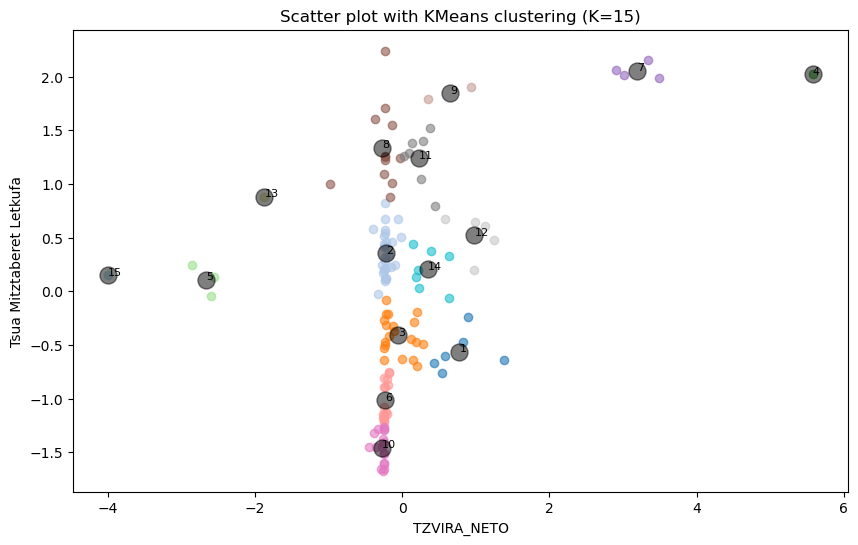

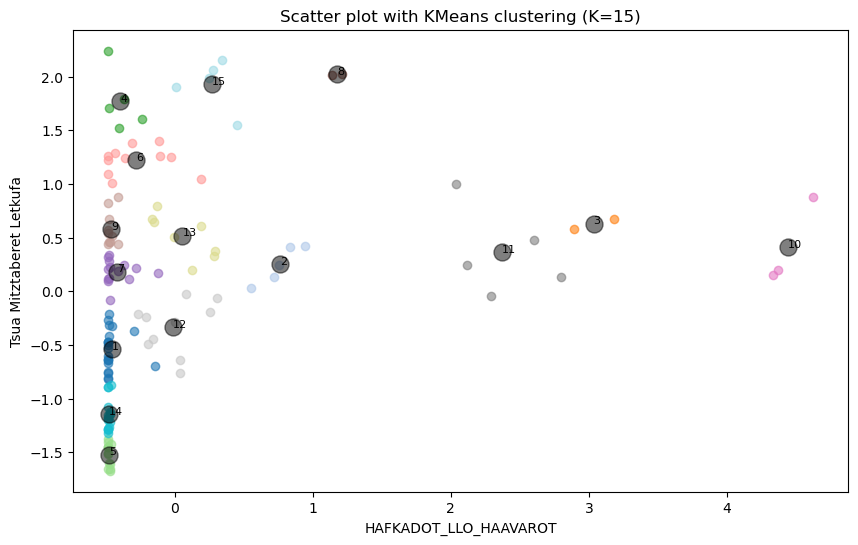

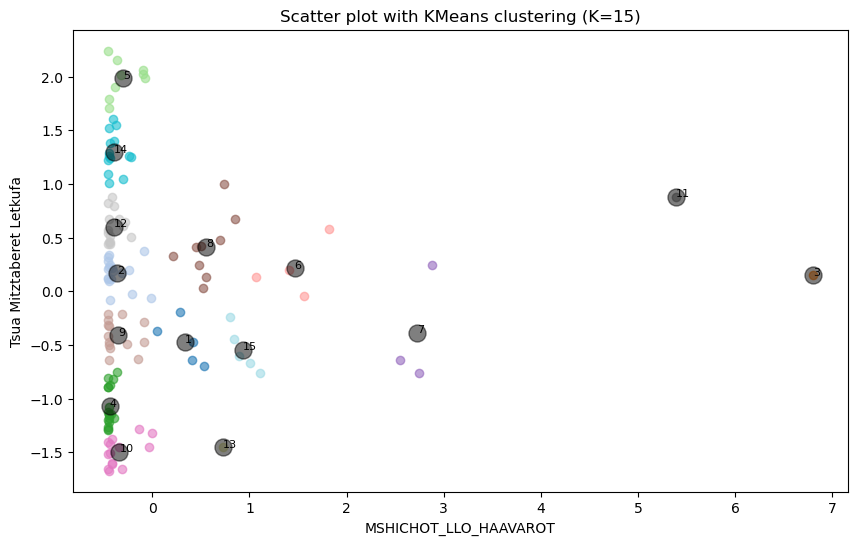

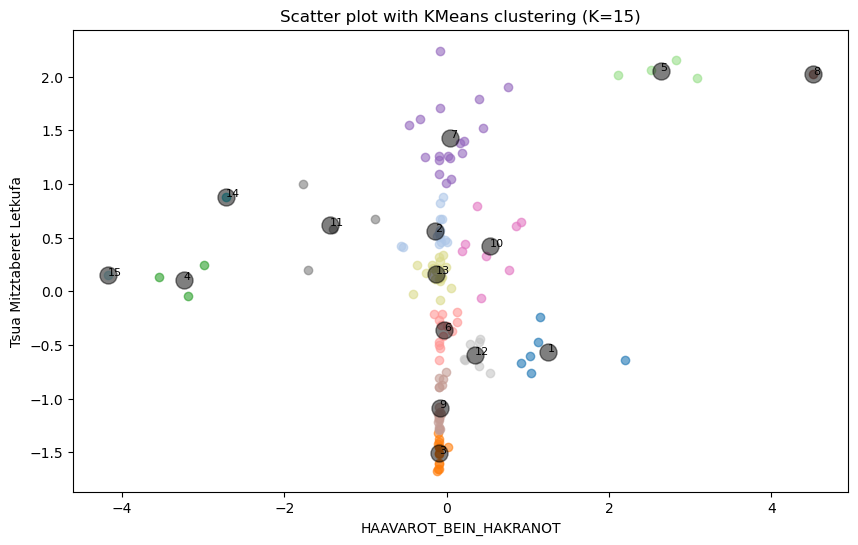

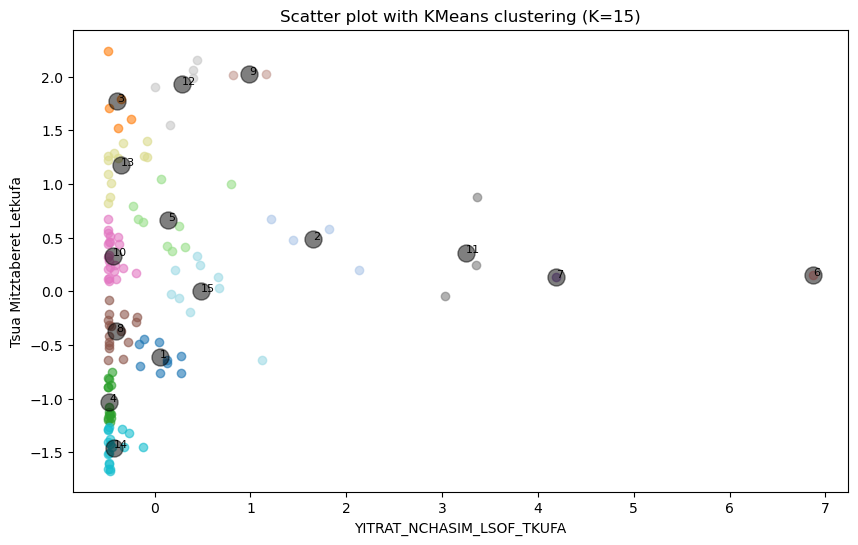

In [231]:
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
data = df_Z_Standardization
x_columns = ['TZVIRA_NETO', 'HAFKADOT_LLO_HAAVAROT', 'MSHICHOT_LLO_HAAVAROT',
             'HAAVAROT_BEIN_HAKRANOT', 'YITRAT_NCHASIM_LSOF_TKUFA']

for col in x_columns:
    kmeans = KMeans(n_clusters=15, random_state=3)
    kmeans.fit(data[[col, 'TSUA_MITZTABERET_LETKUFA']])
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    cmap = cm.get_cmap('tab20', 15)
    plt.figure(figsize=(10, 6))
    for i in range(15):
        cluster_color = cmap(i)
        plt.scatter(data.loc[labels == i, col],
                    data.loc[labels == i, 'TSUA_MITZTABERET_LETKUFA'],
                    label=f'Cluster {i + 1}',
                    color=cluster_color, alpha=0.6)
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o', s=150, alpha=0.5, c='black')
    for i, center in enumerate(cluster_centers):
        plt.text(center[0], center[1], str(i+1), fontsize=8, color='black')
    plt.xlabel(col)
    plt.ylabel("Tsua Mitztaberet Letkufa")
    plt.title(f"Scatter plot with KMeans clustering (K=15)")

plt.show()



#### 1. Net Accumulation (`TZVIRA_NETO`) vs Cumulative Return (`TSUA_MITZTABERET_LETKUFA`)

- **X-axis:** Net Accumulation (Deposits + Transfers − Withdrawals) at the end of the period  
- **Y-axis:** Cumulative return of the pension fund for the period  

**Extreme Clusters:**
- **Cluster 15:** "Menora Mivtachim Pension – General" – very low net accumulation but average cumulative return (likely started with a high initial fund balance)  
- **Cluster 4:** "Harel Pension – S&P 500 Tracker" – high net accumulation and high cumulative return; a very successful fund  

**Pattern:**  
- Some funds with low accumulation achieved high returns (Cluster 15), while others with high accumulation also succeeded (Cluster 4).  
- The relationship is **not strictly linear**, indicating success depends on initial fund status, not just net accumulation.

---

#### 2. Deposits (`HAFKADOT_LLO_HAAVAROT`) vs Cumulative Return

- **X-axis:** Deposits at the end of the period  
- **Y-axis:** Cumulative return  

**Extreme Clusters:**
- **Cluster 10:** Funds with high deposits, average cumulative return (mostly tracks for individuals under 50)  
- **Cluster 5:** Funds with low deposits and low cumulative return (low-risk “money market” funds)  

**Pattern:**  
- No clear visual trend; returns are determined by **investment performance**, not deposit amounts.  
- New contributions do not immediately affect cumulative return due to investment lag.

---

#### 3. Withdrawals (`MSHICHOT_LLO_HAAVAROT`) vs Cumulative Return

- **X-axis:** Withdrawals at the end of the period  
- **Y-axis:** Cumulative return  

**Extreme Clusters:**
- **Cluster 3:** "Menora Mivtachim Pension – General" – high withdrawals, average return  
- **Cluster 11:** "Phoenix Pension – Track for under 50" – high withdrawals, slightly above-average return  

**Pattern:**  
- Withdrawals do not directly determine cumulative return, which depends on **investment performance and fund management**, not withdrawal timing.

---

#### 4. Transfers from Competing Funds (`HAAVAROT_BEIN_HAKRANOT`) vs Cumulative Return

- **X-axis:** Transfers into the fund from competitors  
- **Y-axis:** Cumulative return  

**Extreme Clusters:**
- **Cluster 15:** "Menora Mivtachim Pension – General" – low transfers, average return  
- **Cluster 8:** "Harel Pension – S&P 500 Tracker" – high transfers, very high return  

**Pattern:**  
- Transfers do not immediately impact returns; returns are **driven by past and ongoing investment performance**, not inflows from other funds.

---

#### 5. Fund Value at End (`YITRAT_NCHASIM_LSOF_TKUFA`) vs Cumulative Return

- **X-axis:** Fund value at the end of the period  
- **Y-axis:** Cumulative return  

**Extreme Clusters:**
- **Clusters 6 & 7:** High fund values, average returns  
  - Cluster 6: "Menora Mivtachim Pension – General"  
  - Cluster 7: "Migdal Comprehensive Personal – General"  

**Pattern:**  
- Cumulative return does **not directly depend on fund size**.  
- Returns are determined by **investments performance**, not the total assets in the fund.


### Conclusion

Our conclusion is that there is **no direct relationship between pension fund cash movements and fund returns**. The lack of correlation between fund movements and returns can be explained by several main reasons:

**A. Returns depend on investments, not fund size:**  
The return of a pension fund is determined by the performance of its investments, not by the amount of money in the fund. A fund can maintain positive returns even if its total assets fluctuate due to cash inflows or outflows, because returns reflect profits or losses from financial assets like stocks, bonds, or real estate. Changes in fund size do not necessarily cause direct changes in returns, as returns reflect investment performance rather than the total capital managed.

**B. Cash transfers do not immediately affect investment performance:**  
Movements of money into or out of a fund, such as transfers from other funds, do not immediately affect returns. For example, new transfers may be invested and generate future returns, but they do not necessarily impact the return measured during the current period. Withdrawals or transfers may change the fund size, but do not directly alter the profits from existing investments.

**C. Transfers do not necessarily change the investment strategy:**  
When funds are transferred into a pension fund, the fund may not immediately adjust its investment strategy. For instance, if the fund follows a long-term strategy in stocks or other conservative assets, cash inflows or outflows may not directly influence short-term investment decisions. This explains why movements in the fund do not have a clear relationship with returns.

**Overall:**  
Cash movements within a pension fund do not necessarily depend on market conditions or investment performance, which makes it difficult to observe a direct relationship between fund movements and measured returns.
